In [0]:
#!unzip facades.zip

In [3]:
import numpy as np 
import pandas as pd 
import scipy
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from skimage import transform
from __future__ import print_function, division

from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
import datetime
import sys
import os
from imageio import imread
print(os.listdir("../content"))

Using TensorFlow backend.


['.config', 'facades', 'facades.zip', 'sample_data']


In [0]:
def load_data(dataset_name,batch_size=1, is_val=False):
        data_type = "train" if not is_val else "val"
        path = glob('../content/%s/%s/*' % (dataset_name, data_type))

        batch_images = np.random.choice(path, size=batch_size)
        img_res=(128,128)
        imgs_A = []
        imgs_B = []
        for img_path in batch_images:
            img = imread(img_path)

            h, w, _ = img.shape
            _w = int(w/2)
            # because in the edges2shoes and maps dataset the input image comes before the ground truth.
            if (dataset_name=="edges2shoes" or dataset_name=="maps"):
                img_A, img_B = img[:, _w:, :],img[:, :_w, :] 
            else:  
                img_A, img_B = img[:, :_w, :], img[:, _w:, :]
            # decreasing the resolution 
            img_A = transform.resize(img_A, img_res)  #Ground Truth image
            img_B = transform.resize(img_B, img_res)  #Input image

            # If training => do random flip , this is a trick to avoid overfitting 
            if not is_val and np.random.random() < 0.5:
                img_A = np.fliplr(img_A)
                img_B = np.fliplr(img_B)

            imgs_A.append(img_A)
            imgs_B.append(img_B)
        #normalizing the images
        imgs_A = np.array(imgs_A)/127.5 - 1.  
        imgs_B = np.array(imgs_B)/127.5 - 1.

        return imgs_A, imgs_B

In [0]:
# This function does the same work as the above, except for the fact that is used during training to load image in batches.
def load_batch( dataset_name,batch_size=1, is_val=False):
        
        data_type = "train" if not is_val else "val"
        
        path = glob('../content/%s/%s/*' % (dataset_name, data_type))
        
        n_batches=int(len(path)/batch_size)
        img_res=(128,128)
        for i in range(n_batches):
            batch = path[i*batch_size:(i+1)*batch_size]
            imgs_A, imgs_B = [], []
            for img in batch:
                img = imread(img)
                h, w, _ = img.shape
                half_w = int(w/2)
                # because in the edges2shoes and maps dataset the input image comes before the ground truth.
                if (dataset_name=="edges2shoes"or dataset_name=="maps"):
                      img_A, img_B = img[:, half_w:, :],img[:, :half_w, :] 
                else:  
                      img_A, img_B = img[:, :half_w, :], img[:, half_w:, :]
                img_A = transform.resize(img_A, img_res)#Ground truth image
                img_B = transform.resize(img_B, img_res)# input image
 # when training => do random flip , this is a trick to avoid overfitting 
                if not is_val and np.random.random() > 0.5:
                        img_A = np.fliplr(img_A)
                        img_B = np.fliplr(img_B)

                imgs_A.append(img_A)
                imgs_B.append(img_B)
            # normalizing the images 
            imgs_A = np.array(imgs_A)/127.5 - 1.
            imgs_B = np.array(imgs_B)/127.5 - 1.
            
            #print(imgs_A)
            yield imgs_A, imgs_B
def imread(path):
        return scipy.misc.imread(path, mode='RGB').astype(np.float)

In [0]:
# Input shape
img_rows = 128
img_cols = 128
channels = 3
        
img_shape = (img_rows, img_cols, channels)        
latent_dim = 100

**Basic Generator**

In [0]:
def build_generator():

        model = Sequential()

        model.add(Dense(128 * 8 * 8, activation="relu", input_dim=latent_dim))
        model.add(Reshape((8, 8, 128)))
        
        model.add(UpSampling2D())#upsamples to 16*16*128
        
        model.add(Conv2D(128, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        
        model.add(UpSampling2D()) #upsamples to 32*32*128
        
        model.add(Conv2D(128, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        
        model.add(UpSampling2D()) #upsamples to 64*64*128
        
        model.add(Conv2D(128, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        
        model.add(UpSampling2D()) #upsamples to 128*128*128
        
        model.add(Conv2D(64, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        
        model.add(Conv2D(channels, kernel_size=3, padding="same"))
        model.add(Activation("tanh"))

        #outputs an image of 128*128*3

        noise = Input(shape=(latent_dim,))
        img = model(noise)

        return Model(noise, img)

**Basic Discriminator**

In [0]:
def build_discriminator():

        model = Sequential()

        model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        #no normalization for the first layer 
        
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(ZeroPadding2D(padding=((0,1),(0,1))))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        
        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        
        model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))

        

        img = Input(shape=img_shape)
        validity = model(img)

        return Model(img, validity)

In [9]:
# Build and compile the discriminator
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy',
            optimizer=Adam(0.0002,0.5),
            metrics=['accuracy'])

# Build the generator
generator = build_generator()

# The generator takes noise as input and generates imgs
z = Input(shape=(latent_dim,))
img = generator(z)

# For the combined model we will only train the generator
discriminator.trainable = False

# The discriminator takes generated images as input and determines validity
valid = discriminator(img)

# The combined model  (stacked generator and discriminator)
# Trains the generator to fool the discriminator
combined = Model(z, valid)
combined.compile(loss='binary_crossentropy', optimizer=Adam(0.0002,0.5))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
def show_images( dataset_name,epoch, batch_i):
        
        r, c = 3, 3

        imgs_A, imgs_B = load_data(dataset_name,batch_size=3, is_val=True)
        #fake_A = generator.predict(imgs_B)
        
        noise = np.random.normal(0, 1, (3,latent_dim))
        fake_A = generator.predict(noise)
        
        gen_imgs = np.concatenate([imgs_B, fake_A, imgs_A])

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        titles = ['Input', 'Output', 'Ground Truth']
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt])
                axs[i, j].set_title(titles[i])
                axs[i,j].axis('off')
                cnt += 1
        plt.show()
        plt.close()
        
def show_losses(losses):
    losses = np.array(losses)
    
    fig, ax = plt.subplots()
    plt.plot(losses.T[0], label='Discriminator')
    plt.plot(losses.T[1], label='Generator')
    plt.title("Training Losses")
    plt.legend()
    plt.show()

**Training Process**

In [0]:
def train( dataset_name, epochs, batch_size=1, show_interval=10):
        
        start_time = datetime.datetime.now()

        # Adversarial loss ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))
        #let's add some noise 
        valid += 0.05 * np.random.random(valid.shape)
        fake += 0.05 * np.random.random(fake.shape)
        
        losses=[]
        for epoch in range(1,epochs+1):
            for batch_i, (imgs_A, imgs_B) in enumerate(load_batch(dataset_name,batch_size)):
                #  Train Discriminator
                
                # Sample noise and generate a batch of new images
                noise = np.random.normal(0, 1, (batch_size, latent_dim))
                gen_imgs = generator.predict(noise)

                
                # Train the discriminators (original images = real / generated = Fake)
                d_loss_real = discriminator.train_on_batch(imgs_A, valid)
                d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
                d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
                #print(d_loss)
               
                #  Train Generator
                g_loss = combined.train_on_batch(noise,valid)

                elapsed_time = datetime.datetime.now() - start_time
                
                # Plot the progress
            if epoch%show_interval==0:

                print ("[Epoch %d/%d]  [D loss: %f] [G loss: %f] time: %s" % (epoch, epochs,d_loss[0],g_loss,elapsed_time))
                losses.append((d_loss[0],g_loss))
            #If at show interval => show generated image samples
            if epoch % show_interval == 0:
                    show_images(dataset_name,epoch, batch_i)

        return losses

[Epoch 3400/5000]  [D loss: 0.052905] [G loss: 8.579334] time: 6:15:00.847256
[Epoch 3400/5000]  [D loss: 0.052905] [G loss: 8.579334] time: 6:15:00.847256


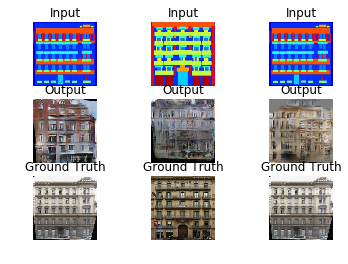

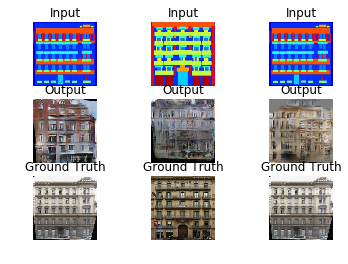

[Epoch 3500/5000]  [D loss: -0.026187] [G loss: 9.350132] time: 6:25:57.018505
[Epoch 3500/5000]  [D loss: -0.026187] [G loss: 9.350132] time: 6:25:57.018505


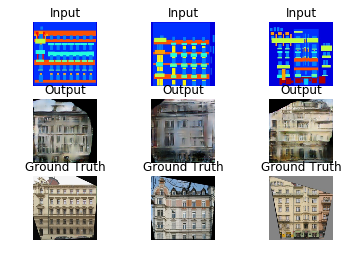

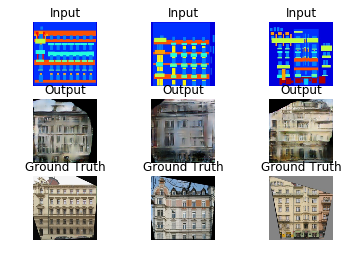

[Epoch 3600/5000]  [D loss: 0.023987] [G loss: 6.557495] time: 6:36:52.089162
[Epoch 3600/5000]  [D loss: 0.023987] [G loss: 6.557495] time: 6:36:52.089162


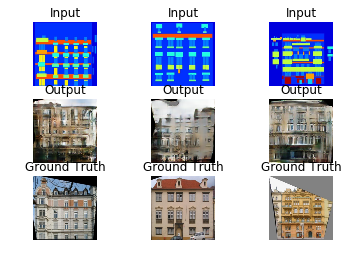

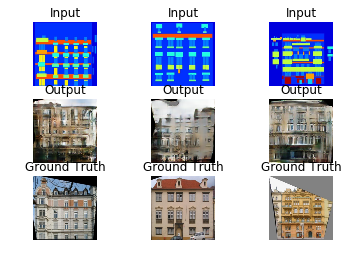

[Epoch 3700/5000]  [D loss: -0.000717] [G loss: 8.121723] time: 6:47:49.028868
[Epoch 3700/5000]  [D loss: -0.000717] [G loss: 8.121723] time: 6:47:49.028868


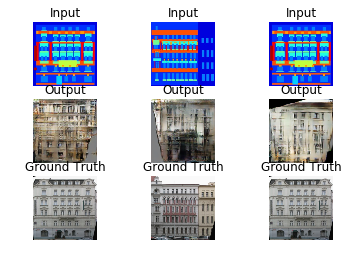

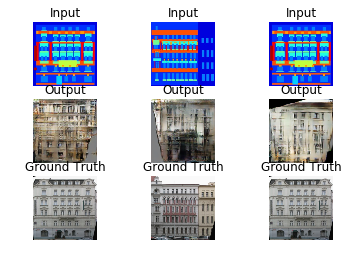

[Epoch 3800/5000]  [D loss: 0.036941] [G loss: 7.810015] time: 6:58:45.273927
[Epoch 3800/5000]  [D loss: 0.036941] [G loss: 7.810015] time: 6:58:45.273927


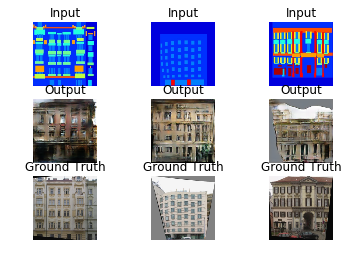

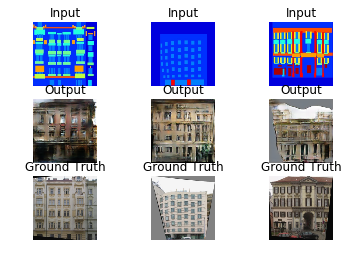

[Epoch 3900/5000]  [D loss: 0.052003] [G loss: 6.810561] time: 7:09:44.487400
[Epoch 3900/5000]  [D loss: 0.052003] [G loss: 6.810561] time: 7:09:44.487400


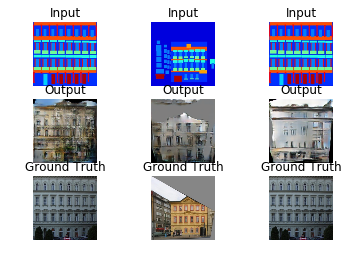

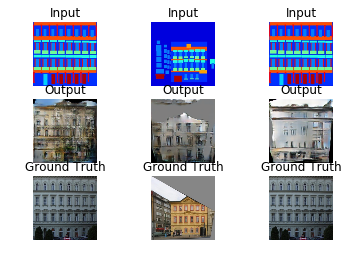

[Epoch 4000/5000]  [D loss: -0.048146] [G loss: 7.280655] time: 7:20:57.383771
[Epoch 4000/5000]  [D loss: -0.048146] [G loss: 7.280655] time: 7:20:57.383771


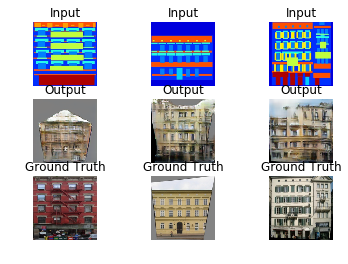

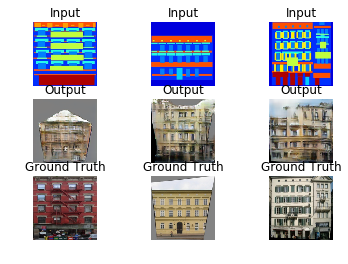

[Epoch 4100/5000]  [D loss: -0.026441] [G loss: 9.471619] time: 7:32:14.754860
[Epoch 4100/5000]  [D loss: -0.026441] [G loss: 9.471619] time: 7:32:14.754860


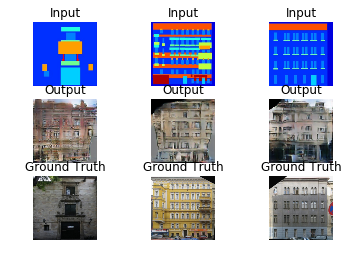

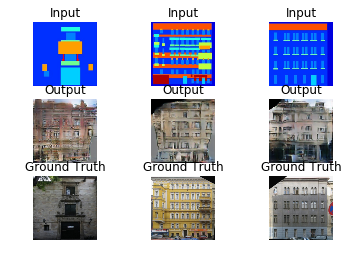

[Epoch 4200/5000]  [D loss: -0.041238] [G loss: 7.879222] time: 7:43:32.271385
[Epoch 4200/5000]  [D loss: -0.041238] [G loss: 7.879222] time: 7:43:32.271385


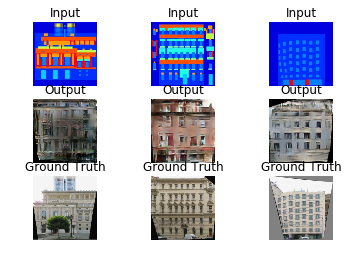

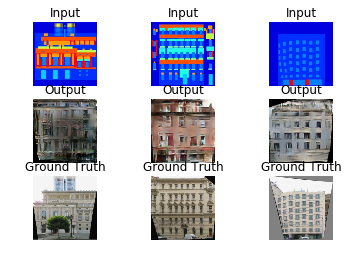

[Epoch 4300/5000]  [D loss: 0.044192] [G loss: 11.540758] time: 7:54:49.872227
[Epoch 4300/5000]  [D loss: 0.044192] [G loss: 11.540758] time: 7:54:49.872227


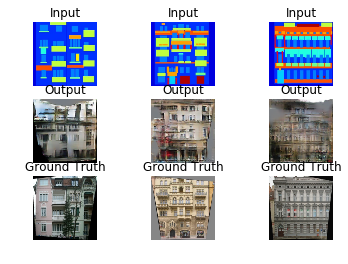

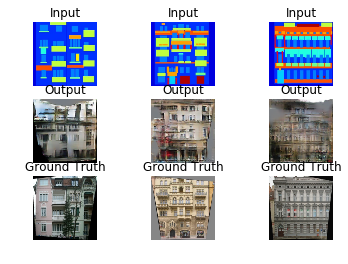

[Epoch 4400/5000]  [D loss: -0.019453] [G loss: 10.004014] time: 8:06:05.024789
[Epoch 4400/5000]  [D loss: -0.019453] [G loss: 10.004014] time: 8:06:05.024789


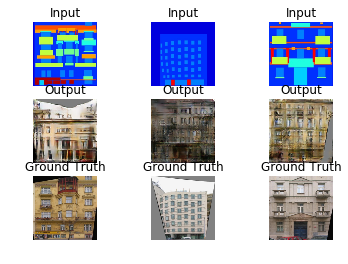

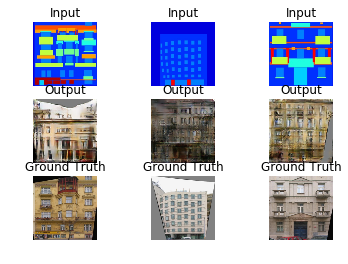

[Epoch 4500/5000]  [D loss: -0.022940] [G loss: 9.959210] time: 8:17:18.555637
[Epoch 4500/5000]  [D loss: -0.022940] [G loss: 9.959210] time: 8:17:18.555637


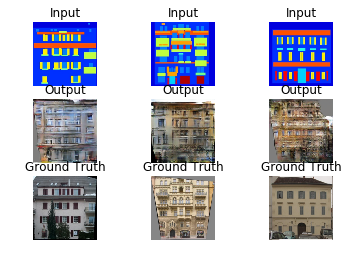

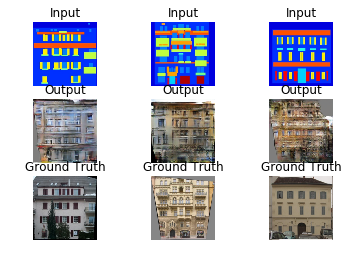

[Epoch 4600/5000]  [D loss: -0.005241] [G loss: 10.240940] time: 8:28:32.172646
[Epoch 4600/5000]  [D loss: -0.005241] [G loss: 10.240940] time: 8:28:32.172646


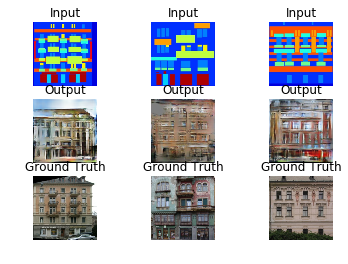

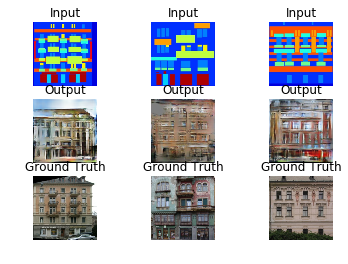

[Epoch 4700/5000]  [D loss: 0.032487] [G loss: 11.223621] time: 8:39:48.534568
[Epoch 4700/5000]  [D loss: 0.032487] [G loss: 11.223621] time: 8:39:48.534568


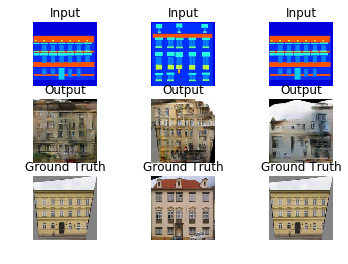

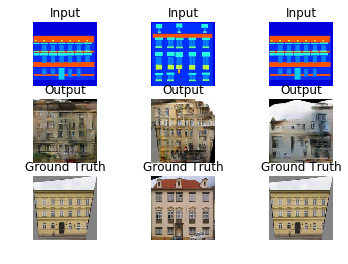

[Epoch 4800/5000]  [D loss: -0.000286] [G loss: 10.321787] time: 8:51:05.503883
[Epoch 4800/5000]  [D loss: -0.000286] [G loss: 10.321787] time: 8:51:05.503883


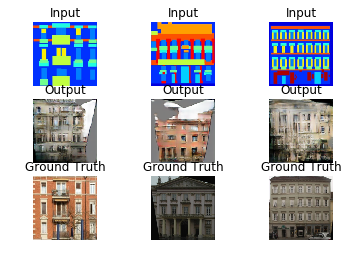

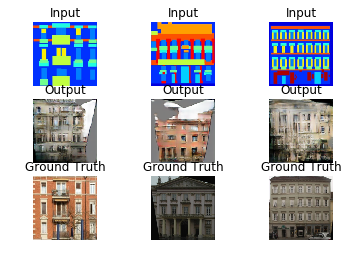

[Epoch 4900/5000]  [D loss: -0.010353] [G loss: 7.855130] time: 9:02:19.655972
[Epoch 4900/5000]  [D loss: -0.010353] [G loss: 7.855130] time: 9:02:19.655972


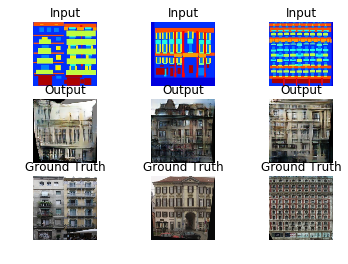

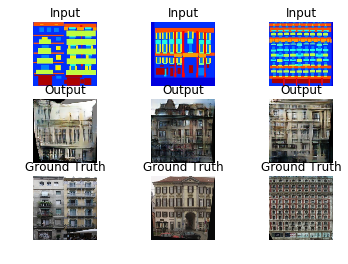

[Epoch 5000/5000]  [D loss: -0.035703] [G loss: 9.014026] time: 9:13:35.316375
[Epoch 5000/5000]  [D loss: -0.035703] [G loss: 9.014026] time: 9:13:35.316375


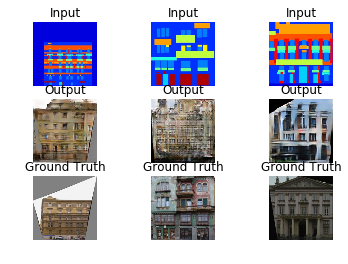

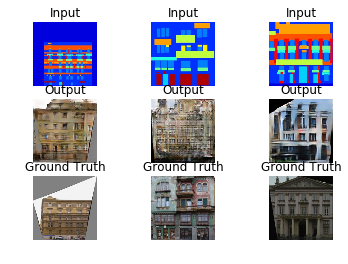

In [12]:
losses = train("facades",epochs=5000, batch_size=32, show_interval=100)

In [0]:
print(losses)